# EnergyPlus Parameterization and Sensitivity Analysis for Residential Single Family Homes


## Daniel Xu, Keller Lab

This notebook was created in order to document the workflow and processes of EnergyPlus within Python. This is for my project involving the parameterization of EnergyPlus. Given that EnergyPlus has over 2000 available inputs, more research needs to be done in order to document which parameters are most significant and relevant in home energy modeling and simulations. 

The goal of this project is to run EnergyPlus on a model single family residential home. Some of the inputs will be fixed to default variables. Other variables, such as window thickness, thermostat set-points, etc. will be varied on pre-defined distributions. 

The distributions will be defined as seen in this paper: 
https://www.sciencedirect.com/science/article/abs/pii/S037877881631372X?via=ihub

### Importing necessary libraries

In [7]:
# For working with IDF files and EnergyPlus
from eppy import modeleditor
from eppy.modeleditor import IDF

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For file and directory operations
import os
import shutil

# For working with time and dates
from datetime import datetime, timedelta

# For HTTP requests
import requests

# For running external commands
import subprocess

# For reading ESO output files
import esoreader

# For working with weather data and EPW files
import diyepw

# For working with directories
import shutil

### Setting EnergyPlus Input Data Dictionary

In [8]:
idd_file_path = "/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/Energy+.idd" # Replace with the path to your EnergyPlus installation
IDF.setiddname(idd_file_path)

### Setting a Skeleton IDF File 

This modifiable IDF file is provided by EnergyPlus in its initial download. It provides a mock residential home in Chicago with multiple zones. I will assume that some of the inputs are fixed and others are varied on a distribution. 

Directly from the EnergyPlus documentation: 

"This file does the basic test of an air distribution system in a residential home. A two speed heat pump with a supplmental gas heater provides space heating and cooling. It provides ventilation through the ZoneAirBalance:OutdoorAir model."

In [9]:
idfname = "../../data/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf"

preidf = IDF(idfname)

Based on this location, we will then use the diyepw package to create time series weather data. More information about diyepw can be found at: 

https://diyepw.readthedocs.io/en/latest/tutorial.html (PNNL)

In [10]:
# Get the current working directory and store it
scripts_dir = os.getcwd()

# Create the output directory if it does not exist
os.makedirs("weather_data", exist_ok=True)

# Changing to this directory
os.chdir("weather_data")

diyepw.create_amy_epw_files_for_years_and_wmos(
  [2023],
  [725300],
  max_records_to_interpolate=6,
  max_records_to_impute=48,
  max_missing_amy_rows=5,
  allow_downloads=True,
  amy_epw_dir='./'
)

# Change back to the scripts directory
os.chdir(scripts_dir)

2025-04-06 14:08:43,911 Creating AMY EPW for year 2023 and WMO 725300...
2025-04-06 14:08:43,914 No amy_dir was specified - downloaded AMY files will be stored in the default location at /jumbo/keller-lab/Applications/mambaforge/envs/eplus/lib/python3.9/site-packages/diyepw/data/noaa_isd_lite_files
2025-04-06 14:08:44,074 TMY EPW file (/jumbo/keller-lab/Applications/mambaforge/envs/eplus/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/USA_IL_Chicago.OHare.Intl.AP.725300_TMY3.epw) already exists, won't download again.
2025-04-06 14:08:44,130 File already exists at ./USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw, so a new one won't be generated.


In [11]:
output_idf_dir = 'randomized_idfs'
    
# Create the output directory if it does not exist
os.makedirs(output_idf_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_idf_dir):
    file_path = os.path.join(output_idf_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

### Editing IDF parameters 



In [12]:
def update_schedule_fields(schedule, new_setpoint, verbose=True):
    """Update every field in a compact schedule that can be interpreted as a number."""
    for i, field in enumerate(schedule.fieldvalues):
        try:
            # Attempt to convert the field to a float.
            float(field)
            # If successful, update that field to the new setpoint.
            schedule.fieldvalues[i] = str(round(new_setpoint, 2))
        except (ValueError, TypeError):
            # If it isn't numeric (e.g., text like 'Through:' or 'For:'), leave it unchanged.
            continue
    if verbose:
        print(f"Updated schedule fields to constant value: {round(new_setpoint, 2)}°C")

In [13]:
def update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True):
    # Load the EnergyPlus IDD file
    IDF.setiddname(idd_file_path)
    if verbose:
        print(f"IDD set from: {idd_file_path}")

    # Means from the original IDF
    mean_heating_sp = 22.0        # °C
    mean_cooling_sp = 26.6        # °C
    mean_people_per_area = 3.0    # people/m²
    mean_infil_flow_rate = 0.01   # m³/s
    mean_watts_equip = 500        # W
    mean_watts_lights = 1000      # W
    mean_heating_COP = 4.0        # for heating coil COP
    mean_fan_efficiency = 0.7     # for fan total efficiency
    mean_pressure_rise = 400.0    # Pa for fan pressure rise
    mean_solar_transmittance = 0.837  # for window glazing
    mean_burner_eff = 0.8         # for natural gas burner efficiency
    mean_vent_flow_rate = 0.131944  # m³/s for ventilation airflow

    # Standard deviation fraction
    sd_frac = 0.05

    # Calculating standard deviations
    sd_heating_sp = sd_frac * mean_heating_sp
    sd_cooling_sp = sd_frac * mean_cooling_sp
    sd_people_per_area = sd_frac * mean_people_per_area
    sd_infil_flow_rate = sd_frac * mean_infil_flow_rate
    sd_mean_watts_equip = sd_frac * mean_watts_equip
    sd_mean_watts_lights = sd_frac * mean_watts_lights
    sd_heating_COP = 0.1 * mean_heating_COP
    sd_fan_efficiency = 0.05 * mean_fan_efficiency
    sd_pressure_rise = 0.1 * mean_pressure_rise
    sd_solar_transmittance = 0.05 * mean_solar_transmittance
    sd_burner_eff = 0.05  # absolute value
    sd_vent_flow_rate = 0.05 * mean_vent_flow_rate

    if verbose:
        print("Starting parameter updates for 10 iterations.")
    for i in range(10):
        if verbose:
            print(f"\n--- Iteration {i+1}/10 ---")
        # Load the IDF file
        idf = IDF(skeleton_idf_path)
        if verbose:
            print(f"Loaded skeleton IDF file: {skeleton_idf_path}")

        # Draw new heating and cooling setpoints from normal distributions
        valid_setpoints = False
        while not valid_setpoints:
            new_heating_setpoint = np.random.normal(mean_heating_sp, sd_heating_sp)
            new_cooling_setpoint = np.random.normal(mean_cooling_sp, sd_cooling_sp)
            if new_heating_setpoint > 0 and new_cooling_setpoint > 0 and (new_cooling_setpoint - new_heating_setpoint > 2):
                valid_setpoints = True
        if verbose:
            print(f"New heating setpoint: {new_heating_setpoint:.2f}°C, cooling setpoint: {new_cooling_setpoint:.2f}°C")

        # Draw new people per area value
        new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        while new_people_per_area < 0.0:
            new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
        if verbose:
            print(f"New people per area: {new_people_per_area:.6f} people/m²")

        # Assign different infiltration rates for different zones
        new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_living < 0.0:
            new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_garage < 0.0:
            new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        while new_infil_flow_rate_attic < 0.0:
            new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
        if verbose:
            print(f"New infiltration rates (m³/s): Living: {new_infil_flow_rate_living:.6e}, Garage: {new_infil_flow_rate_garage:.6e}, Attic: {new_infil_flow_rate_attic:.6e}")

        # Draw new equipment and lighting power values
        new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        while new_watts_equip < 0.0:
            new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
        new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        while new_watts_lights < 0.0:
            new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
        if verbose:
            print(f"New equipment power: {new_watts_equip:.1f} W, new lighting power: {new_watts_lights:.1f} W")

        # Update building parameters
        try:
            people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
            people_object.fieldvalues[5] = new_people_per_area
            if verbose:
                print(f"Updated PEOPLE object 'LIVING ZONE People' with value: {new_people_per_area:.6f}")
        except Exception as e:
            if verbose:
                print("Error updating PEOPLE object:", e)

        try:
            infiltration_object_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
            infiltration_object_living.fieldvalues[5] = new_infil_flow_rate_living
            if verbose:
                print(f"Updated infiltration for Living Zone to: {new_infil_flow_rate_living:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Living Zone:", e)

        try:
            infiltration_object_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
            infiltration_object_garage.fieldvalues[5] = new_infil_flow_rate_garage
            if verbose:
                print(f"Updated infiltration for Garage Zone to: {new_infil_flow_rate_garage:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Garage Zone:", e)

        try:
            infiltration_object_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
            infiltration_object_attic.fieldvalues[5] = new_infil_flow_rate_attic
            if verbose:
                print(f"Updated infiltration for Attic Zone to: {new_infil_flow_rate_attic:.6e}")
        except Exception as e:
            if verbose:
                print("Error updating infiltration for Attic Zone:", e)

        try:
            lighting_object = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
            lighting_object.Lighting_Level = new_watts_lights
            if verbose:
                print(f"Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: {new_watts_lights:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating LIGHTS object:", e)

        try:
            equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
            equipment_object.Design_Level = new_watts_equip
            if verbose:
                print(f"Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: {new_watts_equip:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating ELECTRICEQUIPMENT object:", e)

        # Update Dual Setpoint Schedules for heating
        try:
            heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
            update_schedule_fields(heating_schedule, new_heating_setpoint, verbose)
        except Exception as e:
            if verbose:
                print("Error updating Dual Heating Setpoints:", e)

        # Update Dual Setpoint Schedules for cooling
        try:
            cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
            update_schedule_fields(cooling_schedule, new_cooling_setpoint, verbose)
        except Exception as e:
            if verbose:
                print("Error updating Dual Cooling Setpoints:", e)
        
        # --- Additional Parameter Updates ---

        # 1. Update heating coil COP for 'Heat Pump DX Heating Coil 1'
        try:
            heating_coil = idf.getobject('COIL:HEATING:DX:MULTISPEED', 'Heat Pump DX Heating Coil 1')
            new_COP = np.random.normal(mean_heating_COP, sd_heating_COP)
            heating_coil.Speed_1_Gross_Rated_Heating_COP = new_COP
            heating_coil.Speed_2_Gross_Rated_Heating_COP = new_COP
            if verbose:
                print(f"Updated heating coil COP to: {new_COP:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating heating coil COP:", e)

        # 2. Update fan parameters for 'Supply Fan 1'
        try:
            fan = idf.getobject('FAN:ONOFF', 'Supply Fan 1')
            new_fan_efficiency = np.random.normal(mean_fan_efficiency, sd_fan_efficiency)
            new_pressure_rise = np.random.normal(mean_pressure_rise, sd_pressure_rise)
            # NOTE: The field ordering appears to be:
            # Field 1: Name, Field 2: Availability Schedule, Field 3: Pressure Rise,
            # Field 4: Fan Total Efficiency, Field 5: Maximum Flow Rate, etc.
            # Swap the assignments accordingly:
            fan.fieldvalues[4] = str(round(new_pressure_rise, 1))
            fan.fieldvalues[3] = str(round(new_fan_efficiency, 3))
            if verbose:
                print(f"Updated fan pressure rise to: {new_pressure_rise:.1f} Pa and efficiency to: {new_fan_efficiency:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating fan parameters:", e)

        # 3. Update window solar transmittance for 'CLEAR 3MM' glazing material
        try:
            window_glazing = idf.getobject('WINDOWMATERIAL:GLAZING', 'CLEAR 3MM')
            new_solar_transmittance = np.clip(np.random.normal(mean_solar_transmittance, sd_solar_transmittance), 0, 1)
            window_glazing.fieldvalues[4] = str(round(new_solar_transmittance, 3))
            if verbose:
                print(f"Updated window solar transmittance to: {new_solar_transmittance:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating window glazing solar transmittance:", e)

        # 4. Update natural gas heater burner efficiency for 'Supp Heating Coil 1'
        try:
            heater = idf.getobject('COIL:HEATING:FUEL', 'Supp Heating Coil 1')
            new_burner_eff = np.clip(np.random.normal(mean_burner_eff, sd_burner_eff), 0.7, 0.9)
            # Set the Burner Efficiency at the correct field index (index 4)
            heater.fieldvalues[4] = str(round(new_burner_eff, 3))
            if verbose:
                print(f"Updated burner efficiency to: {new_burner_eff:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating natural gas heater efficiency:", e)

        # 5. Update ventilation airflow rate for 'LIVING ZONE Ventl 1'
        try:
            vent_obj = idf.getobject('ZONEVENTILATION:DESIGNFLOWRATE', 'LIVING ZONE Ventl 1')
            new_vent_flow_rate = np.random.normal(mean_vent_flow_rate, sd_vent_flow_rate)
            # Field index 4 is the Calculation Method, field index 5 is the numeric value.
            vent_obj.fieldvalues[5] = str(round(new_vent_flow_rate, 6))
            if verbose:
                print(f"Updated ventilation design flow rate to: {new_vent_flow_rate:.6f} m³/s")
        except Exception as e:
            if verbose:
                print("Error updating ventilation airflow rate:", e)

        # Save the updated IDF file
        output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
        idf.save(output_file_path)
        if verbose:
            print(f"Saved updated IDF file to: {output_file_path}")


# Example usage:
skeleton_idf_path = idfname  # Assuming idfname is defined elsewhere as the skeleton IDF path.
update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, verbose=True)

IDD set from: /jumbo/keller-lab/Applications/EnergyPlus-24-1-0/Energy+.idd
Starting parameter updates for 10 iterations.

--- Iteration 1/10 ---
Loaded skeleton IDF file: ../../data/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf
New heating setpoint: 22.71°C, cooling setpoint: 27.58°C
New people per area: 3.081664 people/m²
New infiltration rates (m³/s): Living: 1.017754e-02, Garage: 9.880799e-03, Attic: 1.044435e-02
New equipment power: 497.9 W, new lighting power: 991.8 W
Updated PEOPLE object 'LIVING ZONE People' with value: 3.081664
Updated infiltration for Living Zone to: 1.017754e-02
Updated infiltration for Garage Zone to: 9.880799e-03
Updated infiltration for Attic Zone to: 1.044435e-02
Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: 991.8 W
Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: 497.9 W
Updated schedule fields to constant value: 22.71°C
Updated schedule fields to constant value: 27.58°C
Updated heating coil COP to: 4.717
Updated fan

### Running the simulation and outputting the results

In [34]:
output_sim_dir = 'output'
    
# Create the output directory if it does not exist
os.makedirs(output_sim_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_sim_dir):
    file_path = os.path.join(output_sim_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

In [35]:
# Paths to your directories and files
idf_dir = "randomized_idfs"
weather_file = "weather_data/USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw"

In [47]:
def run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir):
    # Set the IDD file path
    IDF.setiddname(idd_file_path)
    
    # Get the list of IDF files
    idf_files = [f for f in os.listdir(output_idf_dir) if f.endswith('.idf')]
    
    for idf_file in idf_files:
        # Define paths
        idf_path = os.path.join(output_idf_dir, idf_file)
        idf_output_dir = os.path.join(output_sim_dir, os.path.splitext(idf_file)[0])
        
        # Create output directory if it doesn't exist
        os.makedirs(idf_output_dir, exist_ok=True)
        
        # Load the IDF file
        idf = IDF(idf_path)
        
        # Save a copy of the IDF file in the output directory
        idf_copy_path = os.path.join(idf_output_dir, os.path.basename(idf_path))
        idf.save(idf_copy_path)
        
        # Run the EnergyPlus simulation
        subprocess.run([
            '/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/energyplus', 
            '--weather', weather_file, 
            '--output-directory', idf_output_dir, 
            '--idd', idd_file_path, 
            '--annual',
            '--readvars',
            idf_copy_path
        ])

run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir)

EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Warming up {8}
Warming up {9}
Warming up {10}
Warming up {11}
Warming up {12}
Warming up {13}
Warming up {14}
Warming up {15}
Warming up {16}
Warming up {17}
Warming up {18}
Warming up {19}
Warming up {20}
Warming up {21}
Warming up {22}
Warming up {23}
Warming up {24}
Warming up {25}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:40
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:40
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:40
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.05 15:40
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2013
Continuing Simulation at 01/21/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2013
Continuing Simulation at 02/10/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2013
Continuing Simulation at 03/02/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2013
Continuing Simulation at 03/22/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2013
Continuing Simulation at 04/11/2013 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2013
C

EnergyPlus Completed Successfully.


### Interpreting Results

In [48]:
all_data_frames = []

for i in range(1,11):
    folder_name = f"randomized_{i}"
    file_path = os.path.join(output_sim_dir, folder_name, "eplusmtr.csv")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path)
        # Tag this data with a Simulation ID
        temp_df["Simulation_ID"] = i
        
        all_data_frames.append(temp_df)
    else:
        print(f"File not found: {file_path}")

# Combine everything into one DataFrame
combined_df = pd.concat(all_data_frames, ignore_index=True)

# Print the first few rows to verify
print(combined_df.head())

# Print some info about the final DataFrame
print("Combined DataFrame shape:", combined_df.shape)

  Date/Time  Electricity:Facility [J](Monthly)  \
0   January                       8.928916e+09   
1  February                       7.260414e+09   
2     March                       7.062259e+09   
3     April                       4.105354e+09   
4       May                       2.712770e+09   

   Electricity:Building [J](Monthly)  InteriorLights:Electricity [J](Monthly)  \
0                       1.856979e+09                             9.599394e+08   
1                       1.637221e+09                             8.391900e+08   
2                       1.727241e+09                             8.879884e+08   
3                       1.688340e+09                             9.196896e+08   
4                       1.695063e+09                             9.599394e+08   

   Electricity:HVAC [J](Monthly)  NaturalGas:Facility [J](Monthly)  \
0                   7.071937e+09                      1.492845e+10   
1                   5.623194e+09                      1.236417e+10   
2 

In [20]:
# Path to the directory where you want to save the CSV
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'

# Create the directory if it does not exist
os.makedirs(analysis_dir, exist_ok=True)

# Create a file path for the output CSV
output_csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

combined_df["Electricity:Facility [J](Monthly)"] = pd.to_numeric(
    combined_df["Electricity:Facility [J](Monthly)"], 
    errors="coerce"
)

# Write the combined DataFrame to CSV
combined_df.to_csv(output_csv_path, index=False)

print(f"Data has been written to: {output_csv_path}")

Data has been written to: /Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis/combined_sims.csv


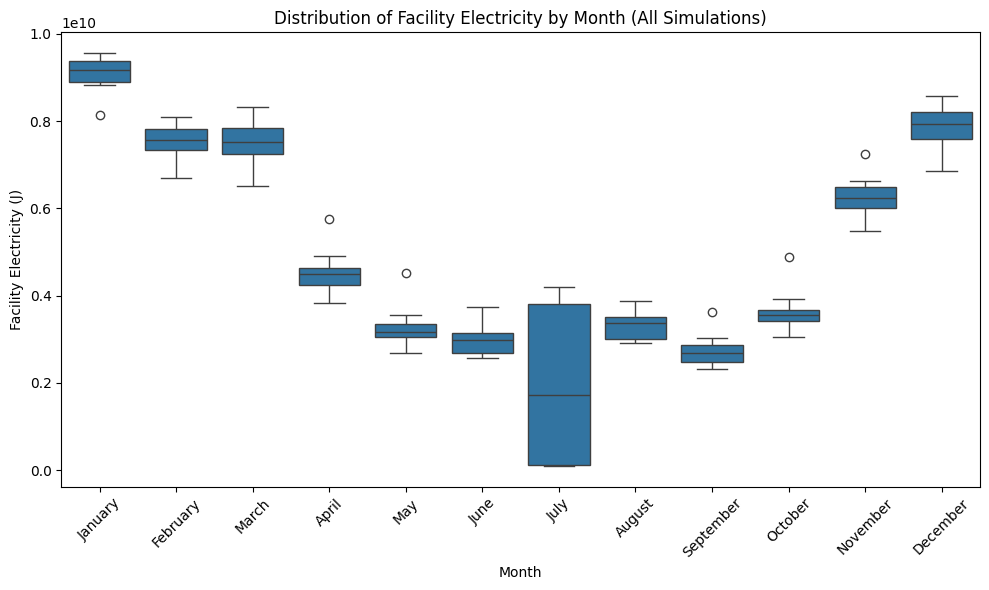

In [21]:
# Example path to your combined CSV file
analysis_dir = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/analysis'
csv_path = os.path.join(analysis_dir, 'combined_sims.csv')

# Load the data
df = pd.read_csv(csv_path)

# -----------------------------------------------------------------------------
# 1) Box Plot - Distribution of Facility Electricity by Month Across Simulations
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Date/Time', y='Electricity:Facility [J](Monthly)', data=df)
plt.title('Distribution of Facility Electricity by Month (All Simulations)')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)  # Rotate month labels if needed
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

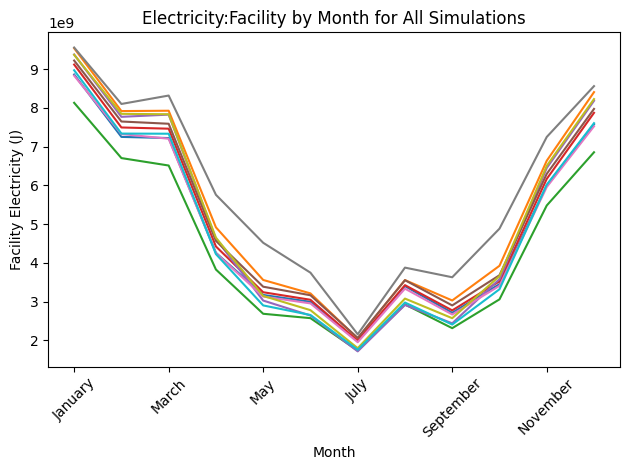

In [22]:
# -----------------------------------------------------------------------------
# 2) Line Plot - Each Simulation's Monthly Electricity Use
# -----------------------------------------------------------------------------
# This approach transforms the DataFrame into wide format, where each Simulation
# has a row, and each Month is a column. Then it plots all simulations as lines.

# Pivot so we have one row per Simulation_ID and one column per Month
# Define your month order
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

# Convert the Date/Time column to a Categorical with the specified order
df["Date/Time"] = pd.Categorical(
    df["Date/Time"], 
    categories=month_order, 
    ordered=True
)

# Now pivot again. The columns will appear in the custom order
pivoted = df.pivot_table(
    index='Simulation_ID',
    columns='Date/Time',
    values='Electricity:Facility [J](Monthly)'
)

# Plot
plt.figure(figsize=(10, 6))
pivoted.T.plot(legend=False)  # Transpose so Months go to the x-axis
plt.title('Electricity:Facility by Month for All Simulations')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

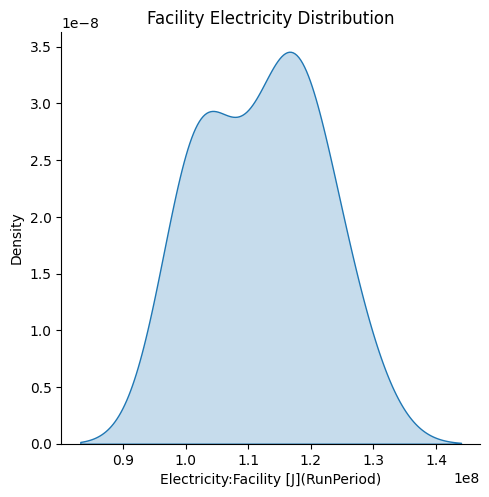

In [23]:
jan_df = df[df["Date/Time"] == "July"]
if not jan_df.empty:
    sns.displot(
        data=jan_df,
        x="Electricity:Facility [J](RunPeriod)",
        kind="kde",
        fill=True
    )
    plt.title("Facility Electricity Distribution")
    plt.show()
else:
    print("No data found for January.")

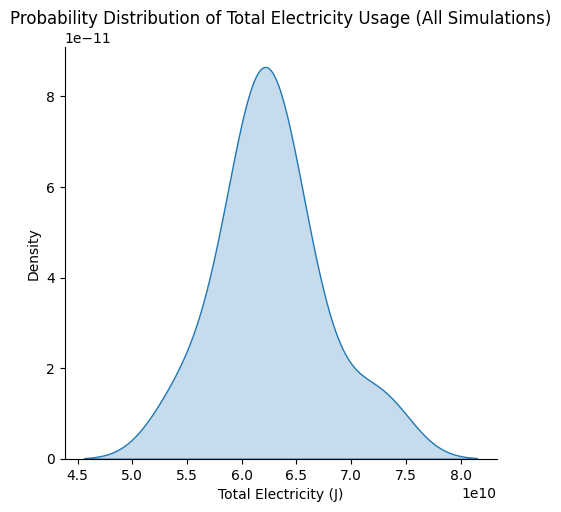

In [24]:
# Assume df has columns "Simulation_ID" and "Electricity:Facility [J](Monthly)"

# Sum the electricity usage for each simulation
df_summed = (
    df
    .groupby("Simulation_ID")["Electricity:Facility [J](Monthly)"]
    .sum()
    .reset_index(name="Total_Electricity")
)

# Plot the probability density of total electricity usage
sns.displot(data=df_summed, x="Total_Electricity", kind="kde", fill=True)
plt.title("Probability Distribution of Total Electricity Usage (All Simulations)")
plt.xlabel("Total Electricity (J)")
plt.ylabel("Density")
plt.show()

In [25]:
PATH_TO_ESO = '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output/randomized_92/eplusout.eso'
eso = esoreader.read_from_path(PATH_TO_ESO)

variables = eso.dd.find_variable('Energy')

print(variables) 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danielxu/Desktop/Dartmouth College/6. Keller Lab/24S/eplus_sensitivity/scripts/output/randomized_92/eplusout.eso'

In [ ]:
index = eso.dd.index[('TimeStep,REPORTSCH', 'ACDXCOIL 1', 'Cooling Coil Total Cooling Energy')]

data = eso.data[index]

print(data)
# print(variables)

In [ ]:
# Define the start date and the time step duration (10 minutes for 6 steps per hour)
start_date = datetime(2024, 1, 1, 0, 0)
time_step_duration = timedelta(minutes=10)

# Define the schedule
schedule = [
    (datetime(2024, 1, 1), datetime(2024, 1, 20), 0.0),
    (datetime(2024, 1, 21), datetime(2024, 1, 21), 1.0),
    (datetime(2024, 1, 22), datetime(2024, 7, 20), 0.0),
    (datetime(2024, 7, 21), datetime(2024, 7, 21), 1.0),
    (datetime(2024, 7, 22), datetime(2024, 12, 31), 0.0),
]

# Generate a list of timestamps and corresponding schedule values
timestamps = []
schedule_values = []
current_time = start_date

for energy_value in data:
    # Find the applicable schedule value for the current time
    schedule_value = next(value for start, end, value in schedule if start <= current_time <= end)
    timestamps.append(current_time)
    schedule_values.append(schedule_value)
    current_time += time_step_duration

# Create the DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Schedule_Value': schedule_values,
    'Energy_Use': data
})

# Show the first few rows of the DataFrame
print(df.head())

# Save the DataFrame to a CSV file (optional)
df.to_csv('aligned_energy_use_data.csv', index=False)